# Experiment  0: ToM Overall Model Performance


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch

In [3]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [4]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [6]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [7]:
# Create a run manager
# run_manager = RunManager('visuals')
# run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Loading graph from ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges
Environment loaded with 3151 nodes and 8746 edges


## Step 2: Create N Agents

In [8]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [9]:
""" Already created agents and saved as pkl
# Create n agents
agents = []
n = 100
for i in range(n):
    agents.append(AgentFactory.create_agent("shortest"))
    agents[i].id = i

n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
    agent.environment = campus

# Save the agents 
import pickle

# suppose `agents` is your list of Agent instances
with open('agents.pkl', 'wb') as f:
    pickle.dump(agents, f)

"""

' Already created agents and saved as pkl\n# Create n agents\nagents = []\nn = 100\nfor i in range(n):\n    agents.append(AgentFactory.create_agent("shortest"))\n    agents[i].id = i\n\nn_goals = len(goals)\nag_alpha = np.random.normal(1, 0.2, size=n_goals)\n\nfor agent in agents: # Set each agent\'s goal distribution\n    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]\n    agent.environment = campus\n\n# Save the agents \nimport pickle\n\n# suppose `agents` is your list of Agent instances\nwith open(\'agents.pkl\', \'wb\') as f:\n    pickle.dump(agents, f)\n\n'

In [10]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

## Step 3: Perform Episodes and Data Collection

In [11]:
import json

In [12]:
"""Already ran once. Data is saved in /data

path_data = {}
goal_data = {}
m = 100
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    path_data[episode] = episode_path_data
    goal_data[episode] = episode_goal_data

with open("./data/path_data.json", "w") as file:
    json.dump(path_data, file, indent=4)

with open("./data/goal_data.json", "w") as file:
    json.dump(goal_data, file, indent=4)
    """


'Already ran once. Data is saved in /data\n\npath_data = {}\ngoal_data = {}\nm = 100\nfor episode in range(m):\n    new_episode(agents)\n    episode_path_data = {}\n    episode_goal_data = {}\n    for agent in agents:\n        agent.plan_path()\n        episode_path_data[agent.id] = agent.path\n        episode_goal_data[agent.id] = agent.goal_node\n    # Save the data from each episode\n    path_data[episode] = episode_path_data\n    goal_data[episode] = episode_goal_data\n\nwith open("./data/path_data.json", "w") as file:\n    json.dump(path_data, file, indent=4)\n\nwith open("./data/goal_data.json", "w") as file:\n    json.dump(goal_data, file, indent=4)\n    '

### Load existing data

In [13]:
import json, pickle

with open("./../data/1k/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./../data/1k/goal_data.json", 'r') as file:
    goal_data = json.load(file)

with open('./../data/1k/agents.pkl', 'rb') as f:
    agents = pickle.load(f)

/tmp/ipykernel_2204197/1732508900.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  agents = pickle.load(f)


In [14]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [15]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the Models
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

### BToM

In [30]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [31]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [32]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        # Filter path to only include valid nodes in the graph
        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]
        if len(valid_path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, valid_path)
    # Reset the posteriors for new episode
    btom.reset_posteriors()

In [33]:
import pickle
with open('./../data/1k_posteriors/btom_posteriors.pkl', 'wb') as f:
    pickle.dump(posteriors_data, f)

In [34]:
import json
with open('./../data/1k_posteriors/btom_posteriors.json', 'w') as f:
    json.dump(posteriors_data, f, indent=2)

### Extended BToM

In [35]:
# Import BToM baseline
from real_world_src.models.extended_btom import Extended_BToM

In [36]:
ext_btom = Extended_BToM(campus, agents, goals)

Computing shortest paths...
Done


In [37]:
# Calculate all the posteriors using the first 30 episode
ext_posteriors_data = {}

for episode in range(len(goal_data)):
    ext_posteriors_data[episode] = {}
    for agent in agents:
        # Filter path to only include valid nodes in the graph
        valid_path = [n for n in path_data[episode][agent.id] if n in ext_btom.campus.G.nodes]
        if len(valid_path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        ext_posteriors_data[episode][agent.id] = ext_btom.update_agent_posterior_over_path(agent, valid_path)

In [38]:
# Save extended BToM to load for other experiments
# suppose `agents` is your list of Agent instances
with open('./../data/1k_posteriors/extended_btom.pkl', 'wb') as f:
    pickle.dump(ext_posteriors_data, f)

In [39]:
import json
with open('./../data/1k_posteriors/ebtom_posteriors.json', 'w') as f:
    json.dump(ext_posteriors_data, f, indent=2)

In [73]:
import pickle
with open('./../data/1k_posteriors/ebtom_posteriors.pkl', 'wb') as f:
    pickle.dump(ext_posteriors_data, f)

# To get posterior data

In [40]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

### LSTM

In [41]:
# Import LSTM model and helpers
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior, predict_goal_posteriors_along_path
)
from torch.utils.data import DataLoader

In [42]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [43]:
# Prepare dataset and dataloader
# Batch size = 32
# Filter all paths to only include valid nodes in node2idx
valid_path_data = {}
for episode in path_data:
    valid_path_data[episode] = {}
    for agent_id, path in path_data[episode].items():
        valid_path = [n for n in path if n in node2idx]
        valid_path_data[episode][agent_id] = valid_path

lstm_dataset = LSTMDataset(valid_path_data, goal_data, node2idx, goal2idx)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)

In [44]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [45]:
# Instantiate and train the model
lstm_model = SimpleLSTM(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)  # Learning rate =0.001
train_lstm_model(lstm_model, lstm_loader, optimizer, device, num_epochs=10)


Epoch 1/10 - Loss: 2.2768
Epoch 2/10 - Loss: 1.9212
Epoch 3/10 - Loss: 1.2890
Epoch 4/10 - Loss: 1.0513
Epoch 5/10 - Loss: 0.2549
Epoch 6/10 - Loss: 0.0798
Epoch 7/10 - Loss: 0.0599
Epoch 8/10 - Loss: 0.0361
Epoch 9/10 - Loss: 0.0035
Epoch 10/10 - Loss: 0.0246


In [46]:
# Evaluate the model
evaluate_lstm_model(lstm_model, lstm_loader, device)

Evaluation accuracy: 0.9973


0.99734

In [47]:
"""
# Compute posteriors along paths for all agents/episodes
lstm_posteriors = {}

for episode in range(len(goal_data)):
    lstm_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        lstm_posteriors[episode][agent.id] = posteriors_along_path
        """

'\n# Compute posteriors along paths for all agents/episodes\nlstm_posteriors = {}\n\nfor episode in range(len(goal_data)):\n    lstm_posteriors[episode] = {}\n    for agent in agents:\n        if agent.id not in test_agent_ids:\n            continue\n        # Filter path to only include valid nodes in node2idx\n        path = [n for n in path_data[episode][agent.id] if n in node2idx]\n        posteriors_along_path = []\n        for t in range(1, len(path)+1):\n            subpath = path[:t]\n            posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)\n            posteriors_along_path.append(posterior)\n        lstm_posteriors[episode][agent.id] = posteriors_along_path\n        '

In [48]:
##### NEW
# For each agent and episode, get posteriors along path prefixes
lstm_posteriors = {}
for episode in range(len(goal_data)):
    lstm_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        if len(path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        # Get posteriors for each prefix of the path
        posteriors_along_path = predict_goal_posteriors_along_path(
            lstm_model, path, node2idx, goal2idx, device
        )
        lstm_posteriors[episode][agent.id] = posteriors_along_path

In [49]:
import pickle
with open('./../data/1k_posteriors/lstm_posteriors.pkl', 'wb') as f:
    pickle.dump(lstm_posteriors, f)

In [50]:
import json
with open('./../data/1k_posteriors/lstm_posteriors.json', 'w') as f:
    json.dump(lstm_posteriors, f, indent=2)

In [51]:
####### Earlier implementation of LSTM posteriors ##########
# Compute posteriors along paths for all agents/episodes
"""
lstm_posteriors = {}

for episode in range(len(goal_data)):
    lstm_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        lstm_posteriors[episode][agent.id] = posteriors_along_path
        """

'\nlstm_posteriors = {}\n\nfor episode in range(len(goal_data)):\n    lstm_posteriors[episode] = {}\n    for agent in agents:\n        if agent.id not in test_agent_ids:\n            continue\n        # Filter path to only include valid nodes in node2idx\n        path = [n for n in path_data[episode][agent.id] if n in node2idx]\n        posteriors_along_path = []\n        for t in range(1, len(path)+1):\n            subpath = path[:t]\n            posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)\n            posteriors_along_path.append(posterior)\n        lstm_posteriors[episode][agent.id] = posteriors_along_path\n        '

### GRU

In [52]:
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

In [53]:
# Prepare dataset and dataloader
# Batch size = 32
# Filter all paths to only include valid nodes in node2idx
valid_gru_path_data = {}
for episode in path_data:
    valid_gru_path_data[episode] = {}
    for agent_id, path in path_data[episode].items():
        valid_path = [n for n in path if n in node2idx]
        valid_gru_path_data[episode][agent_id] = valid_path

gru_dataset = GRUDataset(valid_gru_path_data, goal_data, node2idx, goal2idx)
gru_loader = DataLoader(gru_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

In [54]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [55]:
# Instantiate and train the model
gru_model = SimpleGRU(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
train_gru_model(gru_model, gru_loader, optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 0.4668
Epoch 2/10, Loss: 0.0250
Epoch 3/10, Loss: 0.0015
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0053
Epoch 9/10, Loss: 0.0001
Epoch 10/10, Loss: 0.0000


In [56]:
# Evaluate the model
evaluate_gru_model(gru_model, gru_loader, device)


Evaluation accuracy: 1.0000


1.0

In [57]:
from tqdm import tqdm

In [58]:
"""
####### Earlier implementation of GRU posteriors ##########
# Compute posteriors along paths for all test agents/episodes
# Define test_agent_ids for GRU evaluation (use same split as ToMNet)
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

gru_posteriors = {}
for episode in tqdm(range(len(goal_data)), desc="Episode"):
    gru_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        gru_posteriors[episode][agent.id] = posteriors_along_path
        """

'\n####### Earlier implementation of GRU posteriors ##########\n# Compute posteriors along paths for all test agents/episodes\n# Define test_agent_ids for GRU evaluation (use same split as ToMNet)\nn_test = int(0.2 * len(agents))\ntest_agent_ids = [agent.id for agent in agents[-n_test:]]\n\ngru_posteriors = {}\nfor episode in tqdm(range(len(goal_data)), desc="Episode"):\n    gru_posteriors[episode] = {}\n    for agent in agents:\n        if agent.id not in test_agent_ids:\n            continue\n        # Filter path to only include valid nodes in node2idx\n        path = [n for n in path_data[episode][agent.id] if n in node2idx]\n        posteriors_along_path = []\n        for t in range(1, len(path)+1):\n            subpath = path[:t]\n            posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)\n            posteriors_along_path.append(posterior)\n        gru_posteriors[episode][agent.id] = posteriors_along_path\n        '

In [62]:
######### NEW ##############
# --- Compute GRU posteriors along path prefixes for each agent/episode ---
from real_world_src.models.gru import predict_goal_posteriors_along_path

gru_posteriors = {}
for episode in range(len(goal_data)):
    gru_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        if len(path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        # Get posteriors for each prefix of the path
        posteriors_along_path = predict_goal_posteriors_along_path(
            gru_model, path, node2idx, goal2idx, device
        )
        gru_posteriors[episode][agent.id] = posteriors_along_path

In [63]:
import pickle
with open('./../data/1k_posteriors/gru_posteriors.pkl', 'wb') as f:
    pickle.dump(gru_posteriors, f)

[autoreload of numpy._core failed: Traceback (most recent call last):
  File "/home/rahathmalladi/miniconda3/envs/tom/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/home/rahathmalladi/miniconda3/envs/tom/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 560, in superreload
    if not append_obj(module, old_objects, name, obj):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rahathmalladi/miniconda3/envs/tom/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 526, in append_obj
    in_module = hasattr(obj, "__module__") and obj.__module__ == module.__name__
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rahathmalladi/miniconda3/envs/tom/lib/python3.12/site-packages/numpy/core/multiarray.py", line 17, in __getattr__
    fastCopyAndTranspose, _flagdict, from_dlpack, _place, _reconstruct,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

In [64]:
import json
with open('./../data/1k_posteriors/gru_posteriors.json', 'w') as f:
    json.dump(gru_posteriors, f, indent=2)

### ToMNet

In [65]:
from real_world_src.models.tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists
from torch.utils.data import Dataset, DataLoader


In [66]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [67]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)

node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

Number of nodes in node2idx: 3185


In [69]:
import numpy as np

# Adjust the path if needed
node_embeddings = np.load("./../data/data_utils/node2vec_embeddings_3185.npy")

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# the values you trained with:
K     = 10
T_sup = 50
T_q   = 20


model = ToMNet(
    node_embeddings,
    num_nodes = len(all_nodes),
    #num_nodes=3108,
    num_goals = len(goals),
    K     = K,
    T_sup = T_sup,
    T_q   = T_q,
    #h_char= 64, 
    #h_ment = 64, 
    #z_dim = 32
    ).to(device)

state_dict = torch.load(
    "./../trained_models/New_Tomnet_1k_3185_2ep.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './../trained_models/New_Tomnet_1k_3185_2ep.pth'

In [26]:
"""# Earlier implementation, considers only those nodes in the paths
# that were actually visited by the agents in the episodes.
# This is not the same as the nodes in the graph.
# This is useful for the ToMNet model, which only considers the nodes in the paths
# that were actually visited by the agents in the episodes.

all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        all_nodes.update(path)
all_nodes = list(all_nodes)
node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")
"""

'# Earlier implementation, considers only those nodes in the paths\n# that were actually visited by the agents in the episodes.\n# This is not the same as the nodes in the graph.\n# This is useful for the ToMNet model, which only considers the nodes in the paths\n# that were actually visited by the agents in the episodes.\n\nall_nodes = set()\nfor episode in path_data.values():\n    for path in episode.values():\n        all_nodes.update(path)\nall_nodes = list(all_nodes)\nnode2idx = {n: i for i, n in enumerate(all_nodes)}\nprint(f"Number of nodes in node2idx: {len(node2idx)}")\n'

Preparing ToMNet for evaluation

In [ ]:
"""
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)
"""

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [28]:
from tqdm import tqdm

Getting posteriors for test data

In [29]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [30]:

tomnet_posteriors = {}

for episode in tqdm(range(len(goal_data)), desc="Episode"):
    tomnet_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        dists = infer_goal_dists(model, agent.id, episode, path_data, node2idx, goal2idx, K=10, T_sup=50, T_q=20, device=device)
        tomnet_posteriors[episode][agent.id] = get_posterior_format(dists)



Episode: 100%|██████████| 1000/1000 [3:17:07<00:00, 11.83s/it]   


In [41]:
import pickle
with open('tomnet_posteriors.pkl', 'wb') as f:
    pickle.dump(tomnet_posteriors, f)

In [42]:
import json
with open('tomnet_posteriors.json', 'w') as f:
    json.dump(tomnet_posteriors, f, indent=2)

## Load all the posteriors from Arshia!

In [42]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
### Pickle files   

import pickle, json

# BToM posteriors
with open('./../data/1k_posteriors/btom_posteriors.pkl', 'rb') as f:
    posteriors_data = pickle.load(f)

# Extended BToM posteriors
with open('./../data/Arshia_experiment_0/ebtom_posteriors.pkl', 'rb') as f:
    ext_posteriors_data = pickle.load(f)

# GRU posteriors
with open('./../data/Arshia_experiment_0/gru_posteriors.pkl', 'rb') as f:
    gru_posteriors = pickle.load(f)

# LSTM posteriors
with open('./../data/Arshia_experiment_0/lstm_posteriors.pkl', 'rb') as f:
    lstm_posteriors = pickle.load(f)

# ToMNet posteriors
with open('./../data/Arshia_experiment_0/tomnet_posteriors.pkl', 'rb') as f:
    tomnet_posteriors = pickle.load(f)


# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: [0, 1, 2]
GRU episodes: [0, 1, 2]
ToMNet episodes: [0, 1, 2]
LSTM episodes: [0, 1, 2]
Ext BTOM episodes: [0, 1, 2]


### SOTA: Our Model

In [28]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [19]:
# Import our novel SOTA model components
from real_world_src.models.tomnet_causal_ablation_trainer import TomNetCausal, train_pipeline
from real_world_src.models.tomnet_causal_dataloader import CampusDataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [20]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [21]:
# Check if node mapping exists, if not create it first
node_mapping_path = "./../data/1k/node_mapping_3185.pkl"
if not os.path.exists(node_mapping_path):
    print("Node mapping not found. Creating it first...")
    # Initialize data loader in train mode to create the mapping
    data_loader_train = CampusDataLoader(
        data_dir="./../data/1k/",
        node_mapping_path=None,
        save_node_mapping_path=node_mapping_path,
        mode='train'
    )
    print("Node mapping created successfully!")

# Now initialize data loader for evaluation
print("Initializing CampusDataLoader for TomNetCausal evaluation...")
data_loader = CampusDataLoader(
    data_dir="./../data/1k/",
    node_mapping_path=node_mapping_path,
    save_node_mapping_path=node_mapping_path,
    mode='eval'
)

Initializing CampusDataLoader for TomNetCausal evaluation...
Loading campus environment...
Loading graph from ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges
Loading agents...
Loaded 100 agents
Loading path data...
Environment loaded with 3151 nodes and 8746 edges
Loading agents...
Loaded 100 agents
Loading path data...
Path data keys: 1000
Loading goal data...
Goal data keys: 1000
Loading node_id_mapping from ./../data/1k/node_mapping_3185.pkl
Loaded node_id_mapping with 3185 nodes.
[EVAL] Using fixed node_id_mapping with 3185 nodes.
Node ID range: 48865150 to 13015886764
Sequential range: 0 to 3184
Path data keys: 1000
Loading goal data...
Goal data keys: 1000
Loading node_id_mapping from ./../data/1k/node_mapping_3185.pkl
Loaded node_id_mapping with 3185 nodes.
[EVAL] Using fixed node_id_mapping with 3185 nodes.
Node ID range: 48865150 to 13015886764
Sequential range: 0 to 3184


In [48]:
# Get data dimensions
path_data_causal = data_loader.path_data
goal_data_causal = data_loader.goal_data
node_id_mapping = data_loader.node_id_mapping
num_nodes = len(node_id_mapping)
print(f"Number of nodes: {num_nodes}")

# Prepare graph data
print("Preparing graph data...")
graph_data = data_loader.prepare_graph_data(
    save_cuda_path='./../data/1k/graph_data_cuda.pt',
    device=device
)

Number of nodes: 3185
Preparing graph data...


In [49]:
# filepath: /root/Theory-of-mind/notebooks/Campus_Experiment_0.ipynb
print("Initializing TomNetCausal model...")
num_nodes = len(node_id_mapping)  # Should be 3185 for your checkpoint!
print(f"num_nodes for model: {num_nodes}")
model = TomNetCausal(
    node_feat_dim=4,
    num_nodes=num_nodes,
    time_emb_dim=16,
    hidden_dim=128,
    latent_dim=32,
    n_layers=2,
    n_heads=4,
    dropout=0.1,
    use_gat=True
).to(device)

Initializing TomNetCausal model...
num_nodes for model: 3185


In [50]:
model_path = "./../trained_models/totall_loss_node_mapped_tomnet_causal_model_1k_3185_30ep_best.pth"
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}")
else:
    print("sorry")

Loading pre-trained model from ./../trained_models/totall_loss_node_mapped_tomnet_causal_model_1k_3185_30ep_best.pth


In [51]:
# Test the fixed training pipeline
print(f"Current device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

# model_path = "./../trained_models/totall_loss_node_mapped_tomnet_causal_model_1k_3185_30ep_best.pth"
model_path = "./../trained_models/totall_loss_node_mapped_tomnet_causal_model_1k_3185_30ep_best.pth"
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    # Try loading with strict=False to skip mismatched layers
    missing, unexpected = model.load_state_dict(checkpoint, strict=False)
    if missing:
        print("WARNING: Missing keys in state_dict:", missing)
    if unexpected:
        print("WARNING: Unexpected keys in state_dict:", unexpected)
    model.eval()
else:
    print("No pre-trained model found. Training from scratch...")
    # Fixed: Proper device handling for both CUDA and CPU
    gpu_device = 0 if torch.cuda.is_available() else -1
    print(f"Using GPU device: {gpu_device}")
    
    # Train the model using the pipeline with fixed device logic
    train_pipeline(
        epochs=30,
        batch_size=1024,
        log_wandb=True,
        max_seq_len=100,
        top_k=5,
        gpu=gpu_device,  # This will now properly handle -1 for CPU
        data_dir="./../data/1k/",
        node_mapping_path=node_mapping_path,
        save_node_mapping_path=node_mapping_path,
        save_model=True,
        model_save_name="1k/totall_loss_node_mapped_tomnet_causal_model_1k_3185_30ep"
    )

Current device: cuda:0
CUDA available: True
Loading pre-trained model from ./../trained_models/totall_loss_node_mapped_tomnet_causal_model_1k_3185_30ep_best.pth


In [55]:
# Generate TomNet Causal posteriors
print("=== GENERATING TOMNETCAUSAL POSTERIORS ===")

def get_tomnet_causal_posterior_format(dists, goals):
    """
    Convert list of posterior arrays to list of {goal: prob} dicts.
    """
    return [
        {goal: float(prob[i]) for i, goal in enumerate(goals)}
        for prob in dists
    ]

def infer_tomnet_causal_goal_dists(
    model, agent_id, episode, path_data, node_id_mapping, goals, graph_data, 
    max_seq_len=100, device='cpu'
):
    """
    Compute posteriors for TomNet Causal model.
    """
    model.eval()
    if agent_id not in path_data.get(episode, {}):
        return []
    path = path_data[episode][agent_id]
    valid_path = [n for n in path if n in node_id_mapping]
    if len(valid_path) < 2:
        return []
    dists = []
    
    # Ensure graph_data is on the same device as model
    graph_data_device = {}
    for key, value in graph_data.items():
        if isinstance(value, torch.Tensor):
            graph_data_device[key] = value.to(device)
        else:
            graph_data_device[key] = value
    
    with torch.no_grad():
        for t in range(1, min(len(valid_path)+1, max_seq_len+1)):
            partial_path = valid_path[:t]
            path_indices = [node_id_mapping[n] for n in partial_path]
            
            if len(path_indices) < max_seq_len:
                path_indices = path_indices + [0] * (max_seq_len - len(path_indices))
            
            trajectory_data = {
                'node_ids': torch.tensor([path_indices], dtype=torch.long).to(device),
                'timestamps': torch.arange(len(path_indices), dtype=torch.float).unsqueeze(0).to(device),
                'mask': torch.ones(1, len(path_indices), dtype=torch.bool).to(device)
            }
            
            # Use the device-corrected graph_data
            latents, fused, logits = model(trajectory_data, graph_data_device)
            
            # Extract goal logits and convert to probabilities
            goal_logits = []
            for goal in goals:
                if goal in node_id_mapping:
                    goal_idx = node_id_mapping[goal]
                    if goal_idx < logits.shape[1]:
                        goal_logits.append(float(logits[0, goal_idx]))
                    else:
                        goal_logits.append(-float('inf'))
                else:
                    goal_logits.append(-float('inf'))
            
            goal_logits_tensor = torch.tensor(goal_logits, device=device)
            goal_probs = torch.softmax(goal_logits_tensor, dim=0)
            dists.append(goal_probs.cpu().numpy().tolist())
    
    return dists

# Generate original posteriors
tomnet_causal_posteriors = {}

for episode in tqdm(range(len(goal_data)), desc="TomNetCausal Episode"):
    episode_str = str(episode)
    tomnet_causal_posteriors[episode] = {}
    
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        
        agent_id_str = str(agent.id)
        
        dists = infer_tomnet_causal_goal_dists(
            model, agent_id_str, episode_str, path_data_causal, node_id_mapping, goals, graph_data, 
            max_seq_len=100, device=device
        )
        
        if dists:
            tomnet_causal_posteriors[episode][agent.id] = get_tomnet_causal_posterior_format(dists, goals)

print("=== ORIGINAL POSTERIORS GENERATED ===")

=== GENERATING TOMNETCAUSAL POSTERIORS ===


TomNetCausal Episode: 100%|██████████| 1000/1000 [34:21<00:00,  2.06s/it]

=== ORIGINAL POSTERIORS GENERATED ===


In [56]:
# Apply TopK + Temperature boosting
def apply_topk_temp_boost_to_posteriors(posteriors_dict, temperature=0.3, top_k=3, boost_factor=2.0):
    """
    Apply Top-K + Temperature boosting to existing posterior distributions.
    
    Args:
        posteriors_dict: Your existing tomnet_causal_posteriors
        temperature: Lower = sharper distribution (0.1-0.5 recommended)
        top_k: Number of top goals to boost (2-5 recommended) 
        boost_factor: Multiplier for top-k goals (1.5-3.0 recommended)
    
    Returns:
        Enhanced posteriors with boosting applied
    """
    import torch
    import numpy as np
    
    enhanced_posteriors = {}
    
    for episode_key, episode_data in posteriors_dict.items():
        enhanced_posteriors[episode_key] = {}
        
        for agent_key, agent_posteriors in episode_data.items():
            enhanced_agent_posteriors = []
            
            for posterior in agent_posteriors:
                if isinstance(posterior, dict) and len(posterior) > 0:
                    # Convert posterior dict to lists
                    goals_list = list(posterior.keys())
                    probs = list(posterior.values())
                    
                    # Convert to logits (inverse of softmax)
                    probs_tensor = torch.tensor(probs, dtype=torch.float32)
                    # Avoid log(0) by adding small epsilon
                    probs_tensor = torch.clamp(probs_tensor, min=1e-8)
                    logits = torch.log(probs_tensor)
                    
                    # STEP 1: Apply temperature sharpening to logits
                    sharpened_logits = logits / temperature
                    initial_probs = torch.softmax(sharpened_logits, dim=0)
                    
                    # STEP 2: Apply Top-K boosting
                    top_k_values, top_k_indices = torch.topk(initial_probs, min(top_k, len(initial_probs)))
                    
                    # Create boosted probabilities
                    boosted_probs = initial_probs.clone()
                    boosted_probs[top_k_indices] *= boost_factor
                    
                    # STEP 3: Final renormalization
                    final_probs = boosted_probs / torch.sum(boosted_probs)
                    
                    # Convert back to dict format
                    enhanced_posterior = {
                        goal: float(final_probs[i]) 
                        for i, goal in enumerate(goals_list)
                    }
                    
                    enhanced_agent_posteriors.append(enhanced_posterior)
                else:
                    # Keep non-dict posteriors unchanged
                    enhanced_agent_posteriors.append(posterior)
            
            enhanced_posteriors[episode_key][agent_key] = enhanced_agent_posteriors
    
    return enhanced_posteriors

print("=== APPLYING TOP-K + TEMPERATURE BOOSTING ===")

# Configure boosting parameters
boosting_config = {
    "temperature": 0.3,  # Moderate sharpening
    "top_k": 3,         # Boost top 3 goals
    "boost_factor": 2.0  # Double their probability weight
}

print(f"Using boosting: temp={boosting_config['temperature']}, top_k={boosting_config['top_k']}, boost={boosting_config['boost_factor']}")

# Apply boosting to existing posteriors
tomnet_causal_posteriors_boosted = apply_topk_temp_boost_to_posteriors(
    tomnet_causal_posteriors,
    temperature=boosting_config['temperature'],
    top_k=boosting_config['top_k'],
    boost_factor=boosting_config['boost_factor']
)

print("✅ BOOSTING APPLIED TO POSTERIORS!")

=== APPLYING TOP-K + TEMPERATURE BOOSTING ===
Using boosting: temp=0.3, top_k=3, boost=2.0
✅ BOOSTING APPLIED TO POSTERIORS!


In [57]:
# Save original TomNet Causal posteriors
print("=== SAVING ORIGINAL TOMNET CAUSAL POSTERIORS ===")

# Save as pickle
original_pkl_path = "./../data/1k_posteriors/tomnet_causal_posteriors.pkl"
with open(original_pkl_path, 'wb') as f:
    pickle.dump(tomnet_causal_posteriors, f)
print(f"Saved original posteriors as pickle: {original_pkl_path}")

# Save as JSON
original_json_path = "./../data/1k_posteriors/tomnet_causal_posteriors.json"
with open(original_json_path, 'w') as f:
    json.dump(tomnet_causal_posteriors, f, indent=2)
print(f"Saved original posteriors as JSON: {original_json_path}")

# Save boosted TomNet Causal posteriors
print("=== SAVING BOOSTED TOMNET CAUSAL POSTERIORS ===")

# Save as pickle
boosted_pkl_path = "./../data/1k_posteriors/tomnet_causal_posteriors_boosted.pkl"
with open(boosted_pkl_path, 'wb') as f:
    pickle.dump(tomnet_causal_posteriors_boosted, f)
print(f"Saved boosted posteriors as pickle: {boosted_pkl_path}")

# Save as JSON
boosted_json_path = "./../data/1k_posteriors/tomnet_causal_posteriors_boosted.json"
with open(boosted_json_path, 'w') as f:
    json.dump(tomnet_causal_posteriors_boosted, f, indent=2)
print(f"Saved boosted posteriors as JSON: {boosted_json_path}")

print("=== ALL POSTERIORS SAVED SUCCESSFULLY ===")

=== SAVING ORIGINAL TOMNET CAUSAL POSTERIORS ===
Saved original posteriors as pickle: ./../data/1k_posteriors/tomnet_causal_posteriors.pkl
Saved original posteriors as JSON: ./../data/1k_posteriors/tomnet_causal_posteriors.json
=== SAVING BOOSTED TOMNET CAUSAL POSTERIORS ===
Saved boosted posteriors as pickle: ./../data/1k_posteriors/tomnet_causal_posteriors_boosted.pkl
Saved boosted posteriors as JSON: ./../data/1k_posteriors/tomnet_causal_posteriors_boosted.json
=== ALL POSTERIORS SAVED SUCCESSFULLY ===


In [58]:
# Validation check for the generated posteriors
def validate_posterior_distribution(posteriors_dict, model_name="Model", max_samples=3):
    """
    Validate that posterior distributions sum to 1 and are properly formatted.
    """
    print(f"\n--- {model_name} Validation ---")
    
    total_checked = 0
    valid_distributions = 0
    sum_errors = []
    
    sample_count = 0
    
    for episode_key, episode_data in posteriors_dict.items():
        if sample_count >= max_samples:
            break
            
        for agent_key, agent_posteriors in episode_data.items():
            if sample_count >= max_samples:
                break
                
            print(f"\nEpisode {episode_key}, Agent {agent_key}:")
            print(f"  Number of time steps: {len(agent_posteriors)}")
            
            # Check first few time steps
            for i, posterior in enumerate(agent_posteriors[:2]):  # Check first 2 time steps
                if isinstance(posterior, dict):
                    posterior_sum = sum(posterior.values())
                    total_checked += 1
                    
                    print(f"    Step {i}: {len(posterior)} goals, sum = {posterior_sum:.6f}")
                    
                    if abs(posterior_sum - 1.0) < 1e-6:  # Allow small floating point errors
                        valid_distributions += 1
                    else:
                        sum_errors.append(posterior_sum)
                        print(f"        WARNING: Sum ≠ 1.0")
                else:
                    print(f"    Step {i}: Invalid format - {type(posterior)}")
            
            sample_count += 1
    
    print(f"\n--- Summary for {model_name} ---")
    print(f"Total distributions checked: {total_checked}")
    print(f"Valid distributions (sum ≈ 1): {valid_distributions}")
    print(f"Invalid distributions: {total_checked - valid_distributions}")
    
    if sum_errors:
        print(f"Sum errors found: {len(sum_errors)}")
    else:
        print("✅ All distributions sum to 1.0")

# Validate both original and boosted posteriors
validate_posterior_distribution(tomnet_causal_posteriors, "TomNet Causal Original")
validate_posterior_distribution(tomnet_causal_posteriors_boosted, "TomNet Causal Boosted")


--- TomNet Causal Original Validation ---

Episode 0, Agent 80:
  Number of time steps: 28
    Step 0: 15 goals, sum = 1.000000
    Step 1: 15 goals, sum = 1.000000

Episode 0, Agent 81:
  Number of time steps: 64
    Step 0: 15 goals, sum = 1.000000
    Step 1: 15 goals, sum = 1.000000

Episode 0, Agent 82:
  Number of time steps: 22
    Step 0: 15 goals, sum = 1.000000
    Step 1: 15 goals, sum = 1.000000

--- Summary for TomNet Causal Original ---
Total distributions checked: 6
Valid distributions (sum ≈ 1): 6
Invalid distributions: 0
✅ All distributions sum to 1.0

--- TomNet Causal Boosted Validation ---

Episode 0, Agent 80:
  Number of time steps: 28
    Step 0: 15 goals, sum = 1.000000
    Step 1: 15 goals, sum = 1.000000

Episode 0, Agent 81:
  Number of time steps: 64
    Step 0: 15 goals, sum = 1.000000
    Step 1: 15 goals, sum = 1.000000

Episode 0, Agent 82:
  Number of time steps: 22
    Step 0: 15 goals, sum = 1.000000
    Step 1: 15 goals, sum = 1.000000

--- Summary 

## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [76]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

In [77]:
########### Latest.  
# Robust scores for all methods: match path and posterior lengths to avoid IndexError

# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in posteriors_data[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# Extended BToM Scores
ext_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in ext_posteriors_data[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        ext_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# ToMNet Scores (only for test agents)
tomnet_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids or agent.id not in tomnet_posteriors[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        tomnet_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# LSTM Scores
lstm_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids or agent.id not in lstm_posteriors[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        lstm_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# GRU Scores
gru_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids or agent.id not in gru_posteriors[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        gru_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [81]:
# load tomnet_causal_final_scores from TomNet_Causal_Scores.json
import json
with open('./../data/Arshia_experiment_0/TomNet_Causal_Scores.json', 'r') as f:
    tomnet_causal_final_scores = json.load(f)

In [93]:
# ############ Latest 1st Aug Accuracy #############
# # Robust accuracy for all methods: match path and posterior lengths to avoid IndexError

# # BToM Accuracy
# btom_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in posteriors_data[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = posteriors_data[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         btom_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # Extended BToM Accuracy
# ext_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in ext_posteriors_data[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = ext_posteriors_data[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         ext_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # ToMNet Accuracy (only for test agents)
# tomnet_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in tomnet_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = tomnet_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         tomnet_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # LSTM Accuracy
# lstm_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in lstm_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = lstm_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         lstm_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # GRU Accuracy
# gru_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in gru_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = gru_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         gru_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

In [63]:
# # tomnet causal accuracy
# tomnet_causal_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in tomnet_causal_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = tomnet_causal_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         tomnet_causal_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

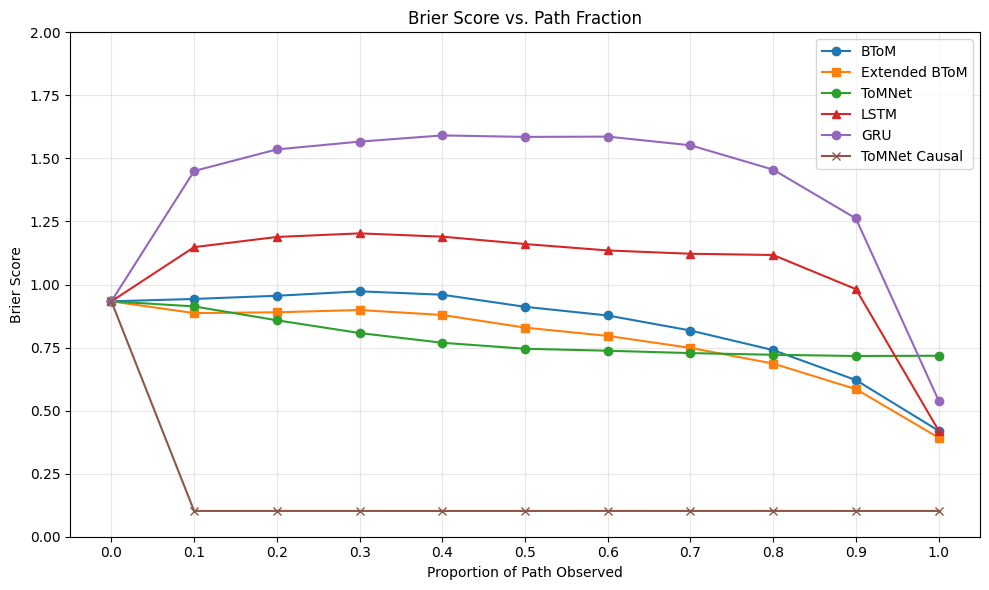

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr  = np.array(ext_scores)
tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_causal_arr = np.array(tomnet_causal_final_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')
plt.plot(props, mean_tomnet_causal, '-x', label='ToMNet Causal')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


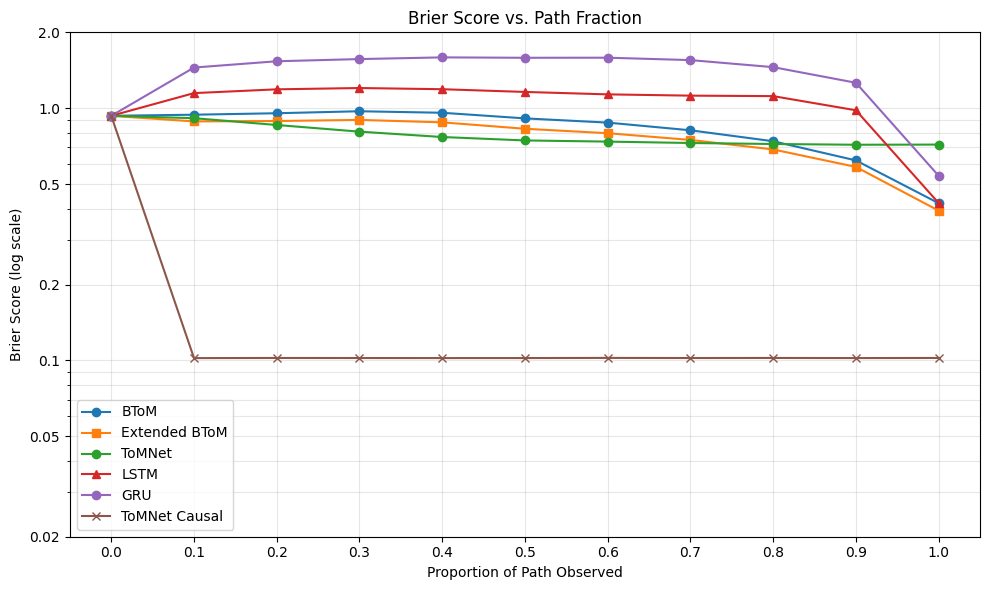

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code for data preparation...
arr = np.array(scores)
ext_arr  = np.array(ext_scores)
tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_causal_arr = np.array(tomnet_causal_final_scores)
props = np.linspace(0, 1, arr.shape[1])

mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')
plt.plot(props, mean_tomnet_causal, '-x', label='ToMNet Causal')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score (log scale)')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.yscale('log')

# Custom Y-axis limits and ticks focused around 10^(-1)
plt.ylim(0.02, 2.0)
plt.yticks([0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], 
           ['0.02', '0.05', '0.1', '0.2', '0.5', '1.0', '2.0'])

plt.grid(alpha=0.3, which='both')  # Show both major and minor grid lines
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Suppose `scores` is your (n_trajectories × n_fractions) array:
# arr = np.array(btom_acc)  # shape (N, 11)
# ext_arr  = np.array(ext_acc)
# tom_arr = np.array(tomnet_acc)
# lstm_arr = np.array(lstm_acc)
# gru_arr = np.array(gru_acc)
# tomnet_causal_arr = np.array(tomnet_causal_acc)
# props = np.linspace(0, 1, arr.shape[1])

# # Compute mean
# mean_base = arr.mean(axis=0)
# mean_ext  = ext_arr.mean(axis=0)
# mean_tom  = tom_arr.mean(axis=0)
# mean_lstm  = lstm_arr.mean(axis=0)
# mean_gru  = gru_arr.mean(axis=0)
# mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

# plt.figure(figsize=(10,6))
# plt.plot(props, mean_base, '-o', label='BToM')
# plt.plot(props, mean_ext,  '-s', label='Extended BToM')
# plt.plot(props, mean_tom, '-o', label='ToMNet')
# plt.plot(props, mean_lstm, '-o', label='LSTM')
# plt.plot(props, mean_gru, '-o', label='GRU')
# plt.plot(props, mean_tomnet_causal, '-x', label='ToMNet Causal')

# plt.xlabel('Proportion of Path Observed')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Path Fraction')
# plt.xticks(props)
# plt.ylim(0, 1)
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

1. Use geospatial coordinates instead of IDs for nodes
2. Consider an embedding for the nodes --  we are using an embedding for the nodes
3. Consider multi head loss
4. Consider other loss functions for the distribution
5. The character net has a strange input where the multiple past trajs are concatenated

# Load existing pickle and json files to plot

1. Run from Step 0 till Step 4 (Models) 
2. Run Step 5
3. Run the following cells

In [ ]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [ ]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
### Pickle files   

import pickle, json

# Example: Load BToM posteriors (adjust path as needed)
with open('./btom_posteriors.pkl', 'rb') as f:
    posteriors_data = pickle.load(f)

# Example: Load GRU posteriors
with open('./gru_posteriors.pkl', 'rb') as f:
    gru_posteriors = pickle.load(f)

with open('./ebtom_posteriors.pkl', 'rb') as f:
    ext_posteriors_data = pickle.load(f)

# Example: Load ToMNet posteriors (can be .pkl or .json)
#with open('./../data/1k/tomnet_posteriors.pkl', 'r') as f:
 #   tomnet_posteriors = pickle.load(f)

# If you have .json files instead, use:
with open('./tomnet_posteriors.pkl', 'rb') as f:
    tomnet_posteriors = pickle.load(f)

with open('./lstm_posteriors.pkl', 'rb') as f:
    lstm_posteriors = pickle.load(f)

# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: [0, 1, 2]
GRU episodes: [0, 1, 2]
ToMNet episodes: [0, 1, 2]
LSTM episodes: [0, 1, 2]
Ext BTOM episodes: [0, 1, 2]


In [ ]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
### JSON files

import pickle, json

# Example: Load BToM posteriors (adjust path as needed)
with open('./btom_posteriors.json', 'r') as f:
    posteriors_data = json.load(f)

# Example: Load GRU posteriors
with open('./gru_posteriors.json', 'r') as f:
    gru_posteriors = json.load(f)

with open('./ebtom_posteriors.json', 'r') as f:
    ext_posteriors_data = json.load(f)

# Example: Load ToMNet posteriors (can be .pkl or .json)
#with open('./../data/1k/tomnet_posteriors.pkl', 'r') as f:
 #   tomnet_posteriors = pickle.load(f)

# If you have .json files instead, use:
with open('./tomnet_posteriors.json', 'r') as f:
    tomnet_posteriors = json.load(f)

with open('./lstm_posteriors.json', 'r') as f:
    lstm_posteriors = json.load(f)

# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: ['0', '1', '2']
GRU episodes: ['0', '1', '2']
ToMNet episodes: ['0', '1', '2']
LSTM episodes: ['0', '1', '2']
Ext BTOM episodes: ['0', '1', '2']


wandb: Currently logged in as: rah-m (rebot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


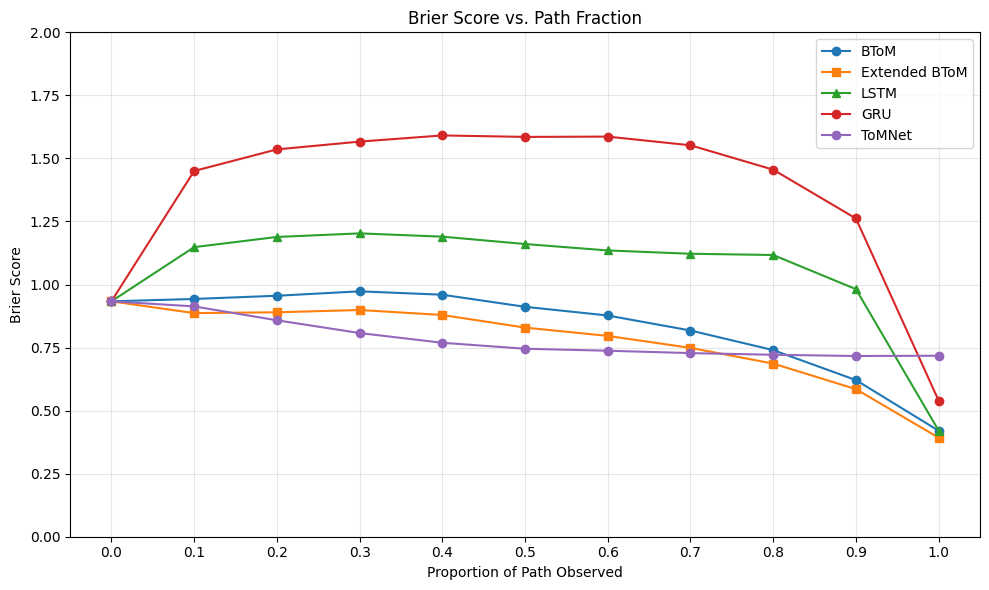

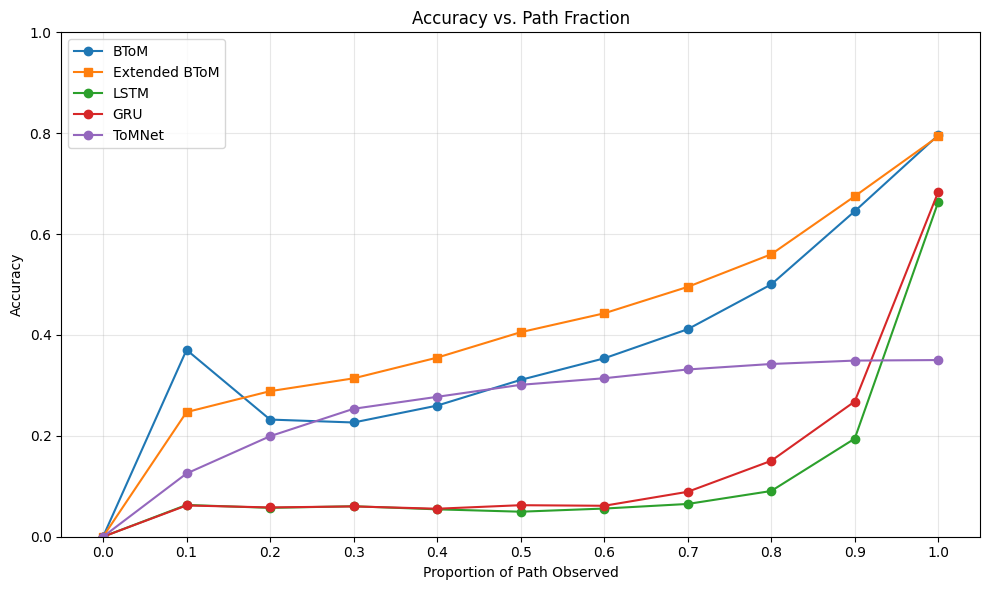

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [36]:
# --- Log Brier Score and Accuracy Plots to Weights & Biases (wandb) ---
import wandb

# Initialize wandb run (set your project name)
wandb.init(project="baseline_experiment0", name="posteriors_analysis")

# Plot and log Brier Score
import numpy as np
import matplotlib.pyplot as plt

arr = np.array(scores)
ext_arr = np.array(ext_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_arr = np.array(tomnet_scores)  
props = np.linspace(0, 1, arr.shape[1])

mean_base = arr.mean(axis=0)
mean_ext = ext_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')
plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
wandb.log({"Brier Score vs. Path Fraction": wandb.Image(plt)})
plt.show()

# Plot and log Accuracy
arr_acc = np.array(btom_acc)
ext_arr_acc = np.array(ext_acc)
lstm_arr_acc = np.array(lstm_acc)
gru_arr_acc = np.array(gru_acc)
tomnet_arr_acc = np.array(tomnet_acc)

mean_base_acc = arr_acc.mean(axis=0)
mean_ext_acc = ext_arr_acc.mean(axis=0)
mean_lstm_acc = lstm_arr_acc.mean(axis=0)
mean_gru_acc = gru_arr_acc.mean(axis=0)
mean_tomnet_acc = tomnet_arr_acc.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base_acc, '-o', label='BToM')
plt.plot(props, mean_ext_acc,  '-s', label='Extended BToM')
plt.plot(props, mean_lstm_acc, '-o', label='LSTM')
plt.plot(props, mean_gru_acc, '-o', label='GRU')
plt.plot(props, mean_tomnet_acc, '-o', label='ToMNet')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
wandb.log({"Accuracy vs. Path Fraction": wandb.Image(plt)})
plt.show()

wandb.finish()